# PAPERS DECONSTRUCTED
## Title: Greedy Function Approximation: A Gradient Boosting Machine
### Authors: Jerome H. Friedman
Link: https://projecteuclid.org/journals/annals-of-statistics/volume-29/issue-5/Greedy-function-approximation-A-gradient-boostingmachine/10.1214/aos/1013203451.full

*Papers deconstructed* are a result of my frustration when reading papers and walking away with a fuzzy understanding. By folding in commentary, Python code implementations, I aim to make the paper much more understandstable to all. I also find it really fun :)

In [310]:
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np

# Abstract

> <i>Function estimation/approximation is viewed from the perspective of
numerical optimization in function space, rather than parameter space</i>

Instead of optimizing for a parameter value (like the slope value in linear regression), we are optimizing for a function directly. This is unusual. ML algorithms are typically designed to optimize over parameter values, not functions directly. We typically calculate something like $\frac{\partial J}{\partial \theta}$ (where J is the cost function and $\theta$ is a parameter value) but here we are calculating something like $\frac{\partial J}{\partial f(x)}$. We take a derivative with respect to a function!

> <i>A connection is made between stagewise additive expansions and steepest descent minimization.</i>

_steepest-descent minimization_ is not the same as _gradient descent_. See this <a href="https://stats.stackexchange.com/a/322177/30545">link</a>. The link also includes a <a href="http://www.math.usm.edu/math/lambers/mat419/lecture10.pdf">reference</a> that's helpful. Steepest-descent minimization is a special case of gradient descent. Gradient descent is using knowledge of the gradient to choose where to step next. But _how_ you take a step, leads you to specific algorithms (such as steepest-descent).

In steepest-descent, the goal is to find a $\alpha$ that minimizes $g$:

$g({\alpha}) = f(x_{t-1} - \alpha \nabla f(x_{t-1})) \;\;\; \alpha \ge 0$

I'm not a numerical specialist, but there's a tradeoff here. While we are exact (as opposed to using a fixed step size), this requires solving an additional optimization problem at each step. I would think the tradeoffs are problem specific.

> <i>A general gradient descent “boosting” paradigm is
developed for additive expansions based on any fitting criterion.</i>

Additive models are models where can break the model into a sum of models:

f(x) = $\sum_i f_i(x)$

Stagewise (say vs stepwise) means we can't go back and edit. Each 'stage' freezes all previous terms. Section **3.3.3 Forward-Stagewise Regression** <a href="https://web.stanford.edu/~hastie/ElemStatLearn/">The Elements of Statistical Learning</a> is helpful.

The boosting paradigm mentioned is a reference to Freund and Schapire's <a href="https://cseweb.ucsd.edu/~yfreund/papers/IntroToBoosting.pdf">paper</a> in the late 90s that introduced the AdaBoost algorithm. The idea of boosting is to build a many models in a sequence. Each model learns from the mistakes from the previous model.

By "any fitting criterion" means that this works (essentially) for any loss function.

> <i>Specific algorithms are presented for least-squares, least absolute deviation, and
Huber-M loss functions for regression, and multiclass logistic likelihood
for classification</i>

Let's show what each of these losses look like mathematically and implemented in code:

**least-squares loss**

$l(y, f) = \frac{1}{2} (y - f)^2$

In [311]:
def least_squares(y_true, y_pred):
    return 0.5 * (y_true - y_pred)**2

# Labels
y = [1, 1, 0, 1, 0]

# True function
f_star = lambda x: x**2

# Estimated function
# (here, we introduce a little bit of error)
f = lambda x: (x + 0.1)**2

# Points to evaluate over
x = np.arange(0, 1, step=0.1)

# In practice, we'd take the average of this
# and try to minimize the average. You will
# see that in this paper
least_squares(f_star(x), f(x))

array([5.000e-05, 4.500e-04, 1.250e-03, 2.450e-03, 4.050e-03, 6.050e-03,
       8.450e-03, 1.125e-02, 1.445e-02, 1.805e-02])

**least-absolute deviation**

$l(y, f) = |y - f|$

In [316]:
def least_absolute_deviation(y_true, y_pred):
    return np.abs(y_true - y_pred)

least_absolute_deviation(f_star(x), f(x))

array([0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19])

**huber-m**

$l(y, f) =  \frac{1}{2} (y - f)^2 \;\;\; |y - f| \le \delta$

otherwise:

$l(y, f) =  \delta(|y - f| - \frac{\delta}{2})$

In [313]:
def huber(y_true, y_pred, delta):
    
    # First take difference (do this once)
    z = y_true - y_pred
    
    # Find points which satisfy first condition
    z_abs = np.abs(z)
    
    z_abs = 
    
    # Which points staisfy hte following?
    I = np.abs(y_true - y_pred) <= delta
    
    return y

huber(f_star(x), f(x), delta=0.1)

array([0.  , 0.01, 0.04, 0.09, 0.16, 0.25, 0.36, 0.49, 0.64, 0.81])

This is the first time I've come across Huber loss. The paper can be found <a href="https://projecteuclid.org/journals/annals-of-mathematical-statistics/volume-35/issue-1/Robust-Estimation-of-a-Location-Parameter/10.1214/aoms/1177703732.full">here</a>. It seems to be a compromise between least-squares and least-absolute deviation. I'm not sure how $\delta$ is chosen in practice. 
    

**multi-class logistic likelihood**

$l(y, f) = - \sum_k y_k log p_k$

In [317]:
def logistic_likelihood(y, f, delta):
    return y

logistic_likelihood(f_star(x), f(x), delta=0.1)

array([0.  , 0.01, 0.04, 0.09, 0.16, 0.25, 0.36, 0.49, 0.64, 0.81])

This is a function we use

> <i>Special enhancements are derived for the particular case
where the individual additive components are regression trees, and tools
for interpreting such “TreeBoost” models are presented.</i>

They also mention that when the additive model is a decision tree (which they give a special name: "TreeBoost") they are able to make specific optimizations.

> <i>Gradient boosting of regression trees produces competitive, highly robust, interpretable procedures for both regression and classification, especially appropriate for
mining less than clean data. Connections between this approach and the
boosting methods of Freund and Shapire and Friedman, Hastie and Tibshirani are discussed.</i>

Lastly, they mention how all this ties in with the famous Adaboost algorithm. Which I believe, was the first boosting algorithm developed.

# 1 Function Estimation

> <i>In the function estimation or "predictive learning" problem, one has a system consisting of a random "output" or "response" variable y and a set of random "input" or "explanatory" variables x = {x1...xn}</i>

You are given labeled data (i.e., training data)

`Using a “training” sample yi xiN
1 ofknown y x-values, the goal is to
obtain an estimate or approximation Fx, ofthe function F∗x mapping
x to y, that minimizes the expected value ofsome specified loss function
Ly Fx over the joint distribution ofall y x-values,
F∗ = arg minF
Ey xLy Fx = arg minF
ExEy (1) Ly Fx  x	`

$F^{*}(x)$ is the true function. Inknown in practice (unless you are simulating data). But we can observe how inputs are relate to the outputs (i.e., labeled data). $F(x)$ is the function we learn from data. But to do this, we need a measure of how good we are doing. Hence, the loss function:

$L(y, F(x)) = L(F^{*}(x), F(x))$.

This loss can output a vector in general, but to keep it simple we have it output a scalar (i.e., a real number). Smaller loss is better (less error).

We need to compute the loss over each (x,y) pair. And, if the data is extremely dense in some regions

A loss will need to be computed for each possible (x,y) pair. And we want to take the average loss (could take the sum, but that can become a very large number quickly). To take an average, divide all x-y space into small little rectangular regions. Now, start sampling from the true function ($F^{*}(x)$). If we record the number of times a point falls in this little region and divide by the number of all points, we get an estimate of $P(x, y)$ for that (x,y) location. The number of points that falled in that region can be recovered by multiplying by its volume (volume = $\Delta x \Delta y$). So number of points $ = \text{probabilty density} * {volume}$

If we do bad in regions that never occur, do we care? The idea is to do well in regions that do occur and not only that, but are very likely to occure. That is, we need a function that assigns a probability to each point in x-y space. This is what $P(x, y)$ gives us. It's known as the joint probability distribution.

average loss = $\int_x \int_y P(x, y) L(y, F(x)) \, dx dy$

You might be used to seeing averages like this:

average loss = $\sum_i \frac{1}{N}x_i$ but in this case, $\frac{1}{N}$ is actually a probability. It's saying each point is equally likely. That's why need the probabilty function of $P(x, y)$. Because each pair is not equally likely in the general case. 

To get the form you see in this paper, I actually answered this many years ago <a href="https://math.stackexchange.com/a/623473/118474">here</a>. But here it is again:

$\int_x \int_y L(y, F(x)) P(x, y) \, dx dy$

By Bayes' theorem: $P(x, y) = P(x) P(y | x)$

Let's substitute

$\int_x \int_y L(y, F(x))  P(x) P(y | x) \, dx dy$

We can rearrange:

$\int_x P(x) \big( \int_y L(y, F(x)) P(y | x) \, dy \big) dx$

And $\int_y L(y, F(x)) P(y | x) dy$ is by definition $E_y [L(y, F(x) | x]$

so 

$\int_x P(x) \big( E_y [L(y, F(x) | x] \big) dx$

But this is again, another expectation. So now we get:

$E_x[E_y [L(y, F(x) | x]]$

Hence:

$F^* = {\text{argmin}}_F \, E_{xy}[L(y, F(x))] = {\text{argmin}}_F \, \int_x \int_y P(x, y) L(y, F(x)) \, dx dy$



`Frequently employed loss functions Ly F include squared-error y − F2
and absolute error y − F for y ∈ R1 (regression) and negative binomial loglikelihood, log1 + e−2yF, when y ∈ −1 1 (classification).`

This is telling us specific cases of what $L(y, F(X))$ can be.

`A common procedure is to restrict Fx to be a member ofa parameterized
class offunctions Fx P, where P = P1 P2 is a finite set ofparameters
whose joint values identify individual class members.`

I will give a concrete example here. Take simple linear regression. That takes the form of:

$F(x) = b + mx$

To rewrite in the notation just given:

$F(x) = p_1 + p_2x$

So $P = {p_1, p_2}$. Note that we fixed the function (basically) and now seek what the values of $b$ and $m$ are. I say basically because technically, each new set of parameters map out a different function. But all functions are restricted to be linear.

`In this article we focus on on “additive” expansions ofthe form
Fx βm amM
1  =
M
m=1
(2) βmhx am`

This additive expansion is saying, we have `m` "mini" models that get added together. Each multiplied by a weight ($\beta_m$. The $m$ denotes which mini-model we are referring to). Each mini-model is denoted as $h(x; a_m)$. The $a_m$ is telling us each mini-model itself has a set of parameters that need to be estimated from data. And these mini-models do not need to share parameters (would be interesting if a technique was developed where some of the mini-models _could_ share parameters).

$h(x; a_m)$ can be a Decision tree, a naive bayes model, etc. IN the package XGBoost this min-model is referred to as the "booster". This is exactly what the next lines are saying:

`The (generic) function hx a in (2) is usually a simple parameterized function ofthe input variables x, characterized by parameters a = a1 a2. The individual terms differ in the joint values am chosen for these parameters.`

Yep. Each model will estimate $a_m$ to have different values than the others.

`Such expansions (2) are at the heart of many function approximation methods such as neural networks [Rumelhart, Hinton, and Williams (1986)], radial
basis functions [Powell (1987)], MARS [Friedman (1991)], wavelets [Donoho
(1993)] and support vector machines [Vapnik (1995)]. Of special interest here
is the case where each ofthe functions hx am is a small regression tree,
such as those produced by CART TM [Breiman, Friedman, Olshen and Stone
(1983)]. For a regression tree the parameters am are the splitting variables,
split locations and the terminal node means ofthe individual trees.`

They mention a bunch of ML models where this type of additive model is applicable. But the one of interest here, is the regression tree (i.e., decision tree). To parameterize this tree, at each node we have to choose a variable and a split point for that variable. So here they are saying that $a_m$ will denote the feature chosen for each node and its split point. We can count the number of parameters. At depth $l$ we will have $2^l$ nodes. So there are:

$\text{number of decision nodes} = \sum_l^{D} 2^l$ where $D$ is the max depth

$\sum_l^{D} 2^l = 2^{D + 1} - 1$ (see <a href="https://math.stackexchange.com/a/1990146/118474">proof</a>)

And two parameters for each node (which variable and its split point):

$ 2 * (2^{D + 1} - 1) = 2^{D + 2} - 2$

I've built models in practice with depths reaching over 10 (even up to 15). So with $D = 15$ we get $131070$ parameters for a single decision tree!

In [187]:
def get_num_params(max_depth):
    n_param = (2**(max_depth + 2) - 2)
    n_param_from_longer_calculation = 2 * sum([2**j for j in range(max_depth + 1)])
    
    # Evidence for proof
    assert n_param == n_param_from_longer_calculation
    
    return n_param

get_num_params(max_depth=15)

131070

`Fx P changes the function optimization problem to one of parameter optimization,
P∗ = arg minP
(3) P
where
P = Ey xLy Fx P
and then
F∗x = Fx P∗
For most Fx P and L, numerical optimization methods must be applied to
solve (3). This often involves expressing the solution for the parameters in the
form
P∗ =
M
m=0
(4) pm
where p0 is an initial guess and pmM
1 are successive increments (“steps” or
“boosts”), each based on the sequence ofpreceding steps. The prescription for
computing each step pm is defined by the optimization method.`

In neural networks, we leverage gradient descent. The weight parameters get updated at each step by adding a value to them. Sp the final weights learned are a sum of the weight updates from each step. That is: 

$\vec{w}_{final} = \sum_i w_i$

We start with an initial guess of parameters ($w_0$) and increment after each step. In the cast of boosting, it's called a boost. But it can really be thought of as a step.

`1.2. Steepest-descent. Steepest-descent is one ofthe simplest ofthe frequently used numerical minimization methods. It defines the increments pmM
1
(4) as follows. First the current gradient gm is computed: where
Pm−1 =
m
−1
i=0
pi
The step is taken to be
pm = −ρmgm
where
ρm = arg minρ (5) Pm−1 − ρgm
The negative gradient −gm is said to define the “steep`

Here, we take the gradient of our loss function with respect to the parameter in context (the $jth$ parameter) for the _mth_ model.

Let's clear this up with some code. Let's apply steepest descent really quick.

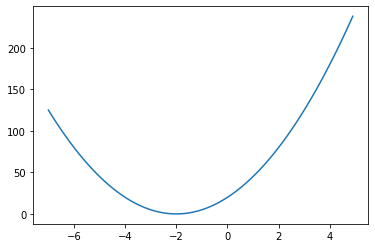

In [205]:
# The function we want to minimize
def f(w):
    return 5*(w + 2)**2

# It's gradient
def grad_f(w):
    return 2 * (w - 5)

w = np.arange(-7, 5, step=.1)

fig, ax = plt.subplots()
ax.plot(w, f(w))

In [270]:
def do_steepest_descent_step(w, f, grad_f, step_size=1.,
                             steepest_descent=False):
    
    # Evaluate current parameter at gradient
    grad = grad_f(w)
    print(f'Grad value: {grad}')
    
    # Dumb brute force approach:
    # try a vector of candidates
    if steepest_descent:
        step_sizes = np.arange(0, 0.3, step=1e-5)
        y = f(w - step_sizes * grad)
        step_size = step_sizes[np.argmin(y)]
        print(f'Best step size: {step_size}')
    
    # We add ""-step_size * grad"
    # to w. So gradient descent is really
    # about adding a bunch of values
    # until we are dones just like the paper
    # points out
    
    w_new = w - step_size * grad
        
    return w_new

In [271]:
w = 5.
for i in range(10):
    print(f'Step {i + 1}')
    print(f'w_before={w}')
    w_new = do_steepest_descent_step(w, f, grad_f, steepest_descent=True)
    if w == w_new:
        print('Convergence reached!')
        break
    w = w_new
    print(f'w_after={w}')
    print('')
print(f'Final value: {w}')

Step 1
w_before=5.0
Grad value: 0.0
Best step size: 0.0
Convergence reached!
Final value: 5.0


`2. Numerical optimization in function space. Here we take a “nonparametric” approach and apply numerical optimization in function space.
That is, we consider Fx evaluated at each point x to be a “parameter” and
seek to minimize`

# 2 Numerical optimiizing in function space

`Here we take a “nonparametric” approach and apply numerical optimization in function space.
That is, we consider Fx evaluated at each point x to be a “parameter” and
seek to minimize
F = Ey xLy Fx = ExEyLy Fx  x	
or equivalently,
φFx = EyLy Fx  x	`

So the idea is to treat $F(x)$ as a parameter. Earlier we showed that $E_x[E_y [L(y, F(x) | x]]$ But if we are optimizing over for $F(X)$ the only thing that really matter is $E_y [L(y, F(x) | x]$. So to make this explicit, we make a new function called $\phi$ that takes in the function $F(x)$ and spits out the expected loss averaged over all labels. But this is conditioned on a specific $x$.

$\phi(F(x)) = E_y [L(y, F(x) | x]$

`at each individual x, directly with respect to Fx. In function space there are
an infinite number ofsuch parameters, but in data sets (discussed below) only
a finite number FxiN
1 are involved.`

But we have to do this at each $x$ If we treat $F(x)$ as a parameter, how many parameters are there? Well for each data point, there exists one function we seek that lowers the loss. I see no reason why that function must be unique, but there definitely exists a class of functions that is lowest for a given $x$.

The process generating the data would typically be continus across $x$. But in practice, we often get a discrete set of (x,y) pairs. So we get $N$ observations.

`Following the numerical optimization
paradigm we take the solution to be
F∗x =
M
m=0
fmx
where f0x is an initial guess, and fmxM
1 are incremental functions
(“steps” or “boosts”) defined by the optimization method.`

So this is a reference back to how gradient descent operates. We continually add values to the parameter. So the same will be done for the function we are learning.

$F(x) = \sum_{m=0} f_m(x)$

which is similar to:

$\vec{w}_{final} = \sum_{i=0} w_i$

For parameters we call this "steps" and in the context of a function, we call this "boosts".

But how do we determine which $f_m$ to use? We rely on the gradient. So we have:

$\phi(F(x)) = E_y [L(y, F(x) | x]$

Taking the derivative with respect to $F(x)$:

$\frac{\partial \phi(F(x))}{\partial F(x)} = \frac{\partial E_y [L(y, F(x) | x]}{\partial F(x)}$

We evaluate this derivative at $F_{m-1}(x)$

And so we add the following increment:

$-\alpha \frac{\partial E_y [L(y, F(x) | x]}{\partial F(x)}$

. The alpha is calculated with the line search, we can also set it to a constant (eta parameter in XGBoost)

`Assuming sufficient regularity that one can interchange differentiation and
integration, this becomes
gmx = Ey
∂Ly Fx
∂Fx  x

Fx=Fm−1x
(7) `

TODO: What does assuming sufficient regularity mean?

# 3 Finite Data

`This nonparametric approach breaks down when the joint
distribution of y x is estimated by a finite data sample yi xiN
1 . In this
case Ey·  x	 cannot be estimated accurately by its data value at each xi, and
even ifit could, one would like to estimate F∗x at x values other than the
training sample points. Strength must be borrowed from nearby data points
by imposing smoothness on the solution.`

There are some problems. How do you estimate a conditional when you have a single data point well? And also, what about points not in the training dataset? Well, we could say something about smoothness. That is, when we start to venture off from a given $x$ things don't change rapidly.

`One way to do this is to assume a
parameterized form such as (2) and do parameter optimization as discussed in
Section 1.1 to minimize the corresponding data based estimate ofexpectedm`

So now the idea is to go back to a parameter optimization problem. The function is assumed to be additive. But we have to estimate each weight for the function and its parameters. Doing this jointly seems really hard when we are adding many such functions. They have a solution for this:

`In situations where this is infeasible one can try a “greedy stagewise”
approach. For m = 1 2M,`

`and then
Fmx = Fm−1 (10) x + βmhx am
Note that this stagewise strategy is different from stepwise approaches that
readjust previously entered terms when new ones are added.`

They reiterate when I had mentioned before. Stagewise vw stepwise. Stagewise just freezes previous terms but stepwise allows for some of them to be adjusted.